In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
from collections import Counter
import numpy as np

from toolbox import *
from h3_tools import *

In [3]:
intervals, T=create_intervals(interval_length_minutes=20)

In [2]:
year=2020
dates=[
    {'month': 3, 'day': d} for d in range(2, 32)] +[
    {'month': 4, 'day': d} for d in range(1, 31)]+ [
    {'month': 5, 'day': d} for d in range(1, 32)]+[
    {'month': 6, 'day': d} for d in range(1, 31)]+[
    {'month': 7, 'day': d} for d in range(1, 32)]+[
    {'month': 8, 'day': d} for d in range(1, 32)]+[
    {'month': 9, 'day': d} for d in range(1, 31)]+[
    {'month': 10, 'day': d} for d in range(1, 30)]

In [24]:
def find_collocations(stay_ind_by_interval, cell_ids_by_stay_ind):
    """
    for every interval, return the memberships of every h3 cell 
    where the membership > 1 
    """
    colocations_by_int=[]
    for s_ind_this_interval in stay_ind_by_interval:
        cell_ids_this_interval=[cell_ids_by_stay_ind[s_ind] for s_ind in s_ind_this_interval]
        n_stays_by_cell_id=Counter(cell_ids_this_interval)
        memberships_all_cells=[]
#         bld_cover_all_cells=[]
        for cell in n_stays_by_cell_id:
#             try:
#                 bld_cover=building_cover_all_cells[cell]
#             except:
#                 bld_cover=-1
            members=n_stays_by_cell_id[cell]
            if ((members>1) 
#                 and (bld_cover>=0)
               ):
                memberships_all_cells.append(members)
#                 bld_cover_all_cells.append(bld_cover)
        colocations_by_int.append({'m': memberships_all_cells
#                                    , 'b': bld_cover_all_cells
                                  })
    return colocations_by_int

In [25]:
def compute_crowding(colocations_all_days):
    dt=1/len(colocations_all_days[0])  # the fraction of 1 day represented by each interval
    crowding_by_day=[]
    for i_d, co_d in enumerate(colocations_all_days):
        if len(co_d)>0:
            crowding_today=0
            for interval in co_d:
                memberships_interval=np.array(interval['m'])
                pot_interactions_interval=np.multiply(memberships_interval, memberships_interval-1)/2
                crowding_today+=np.sum(pot_interactions_interval) 
            crowding_by_day.append(dt* crowding_today)
        else:
            crowding_by_day.append(float('NaN'))
    return crowding_by_day

In [ ]:
crowding_by_res={}
for resolution in [10,11,12]:
    colocations_all_days=[]
    for i_d, date in enumerate(dates):
        month=date['month']
        day=date['day']
        print('{}_{}'.format(month, day))
        try:
            persons=json.load(open('../data/private/stays/{}_{}/stays_{}_{}_{}.json'.format(year, month, year, month, day)))
        except:
            print("Couldn't get data for {}_{}_{}".format(year, month, day))
            persons=[]
        if len(persons)>0:
            stay_ind_by_interval, cell_ids_by_stay_ind=get_h3_cells_by_interval(resolution=resolution, intervals=intervals, 
                                                                                T=T, persons=persons)
            colocations=find_collocations(stay_ind_by_interval, cell_ids_by_stay_ind)
            colocations_all_days.append(colocations)
        else:
            colocations_all_days.append([])
    crowding_by_day=compute_crowding(colocations_all_days)
    crowding_by_res[resolution]=crowding_by_day

In [42]:
crowding_by_res_df=pd.DataFrame.from_dict(crowding_by_res)

In [43]:
crowding_by_res_df.head()

,10,11,12
0,4.654932e+06,1.181462e+06,374903.083333
1,4.386285e+06,1.129056e+06,360169.555556
2,4.250692e+06,1.082654e+06,336153.208333
3,4.539950e+06,1.158518e+06,359117.444444
4,4.740063e+06,1.225771e+06,386934.166667


In [44]:
crowding_by_res_df.corr()

,10,11,12
10,1.000000,0.970832,0.912552
11,0.970832,1.000000,0.981134
12,0.912552,0.981134,1.000000


<AxesSubplot:>

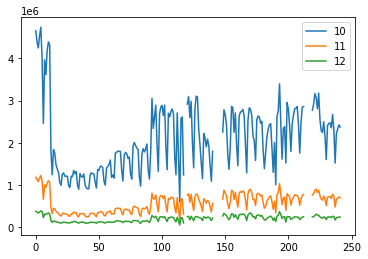

In [45]:
crowding_by_res_df.plot()